----

# **Credit Scoring - Extracting Key Information from Bank & Salary Statement**

----

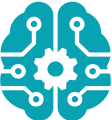

<span style='color:#09a2b3'>**Author:**</span> Ismail Syed & Bob Peulen </br>
<span style='color:#09a2b3'>**Title:**</span> Senior Cloud Specialist </br>
<span style='color:#09a2b3'>**Domain:**</span> Data Science</br></br>


---

# **Four parts:**
- Extracting key values from bank statement
- Extracting key values from salary statement
- Cross-check the results, send e-mails
- Gradio application as GUI

---

# **Key information to change before starting**

In [1]:
#The below refers to using Gmail in sending out e-mails.
# link to set up application password for Gmail: https://support.google.com/mail/answer/185833?hl=en-GB
application_email_adress = "xxx"
application_password = "xxx"

# **Imports**

In [2]:
# when using AI Document Understanding Beta functionality, run the below.
# !pip install oci-2.88.2+preview.1.5970-py2.py3-none-any.whl

In [3]:
import oci
import uuid
import base64
import json
import cv2
import pandas as pd
import fitz
import gradio as gr
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import IFrame
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing, svm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import numpy as np
import random
import gradio as gr
import smtplib
from email.message import EmailMessage

</br><h3 style='color:#09a2b3'> Authentication </h3>

In [4]:
# Check Authentication with OCI
def oci_authenticate(debug):
    
    # Set up and read in config file to authenticate against OCI
    config = oci.config.from_file('~/.oci/config', 'DEFAULT')

    # Create a Service Client to Identity API
    identity = oci.identity.IdentityClient(config)

    # Check if successful response received
    if identity.get_user(config['user']).status == 200:
        
        # Get the current User Information from API
        user = identity.get_user(config['user']).data

        if debug == 'y':
            print('\nAuthentication Successful!')
            print('\nOCI User Logged In:', user.name)
            print('OCI User Email:', user.email)
    else:
        print('Authentication Failed!')
        print('HTTP Request Error Code:', identity.get_user(config['user']).status)

    # Return config object to be used to initialise AI Language Client
    return config

# Authenticate against OCI
config = oci_authenticate('y')


Authentication Successful!

OCI User Logged In: oracleidentitycloudservice/bob.peulen@oracle.com
OCI User Email: None


----------

# **1. Extracting key values from Bank Statement**

-----------

## **1.1 Read in Bank Statement PDF**

In [5]:
# Define PDF Document
document = r"bank_statement_1.pdf"

# Remove Document Extension - Used later when save with new extension
document_no_ext = document[:-4]

# Encode PDF Document as base64
with open(document, "rb") as document_file:
    document_encoded = base64.b64encode(document_file.read()).decode('utf-8')

In [6]:
# Preview PDF Document
display(IFrame(document, width=1000, height=600))

## **1.2 Send Bank statement to Custom Key Value Model**

In [7]:
def kv_extraction(config, document_encoded):
    
    # Compartment where Processor Job will be created
    COMPARTMENT_ID = "ocid1.compartment.oc1..aaaaaaaae3n6r6hrjipbap2hojicrsvkzatrtlwvsyrpyjd7wjnw4za3m75q"
    
    ### bank statement model
    # Custom MP DUS Key Value Model ID
    MODEL_ID = "ocid1.aidocumentmodel.oc1.eu-frankfurt-1.amaaaaaangencdyany5dhod57upaemwitgsffjx4gmov2befya5wefck32rq"
    
    # Define AI Services Client
    aiservicedocument_client = oci.ai_document.AIServiceDocumentClient(config=config)
    
    # Instantiate Document Key-Value Feature - Pass in Model ID
    key_value_extraction_feature = oci.ai_document.models.DocumentKeyValueExtractionFeature(model_id=MODEL_ID)

    # Save to a list - add multiple DUS features here if required
    features = [key_value_extraction_feature]
    
    # Define Document Input
    input_loc = oci.ai_document.models.InlineDocumentContent(data=document_encoded)
    
    # Setup the Output Location where the Job Results will be stored
    output_location = oci.ai_document.models.OutputLocation()
    output_location.namespace_name = "frqap2zhtzbe"
    output_location.bucket_name = "West_BP"
    output_location.prefix = "DocumentUnderstanding_output"


    # Define the Features for DUS
    processor_config = oci.ai_document.models.GeneralProcessorConfig(features=features)
    
    # Create a Job for Key Value Extraction Feature
    kv_job_details = oci.ai_document.models.CreateProcessorJobDetails(
                        display_name=str(uuid.uuid4()),
                        compartment_id=COMPARTMENT_ID,
                        input_location=input_loc,
                        output_location=output_location,
                        processor_config=processor_config)

    # Extecute DUS Job - Response is an Object pointing to Deatils of Job
    processor_response = aiservicedocument_client.create_processor_job(create_processor_job_details=kv_job_details)

    print("Processor call succeeded with status: {}.\n\n".format(processor_response.status))
    
    
    return processor_response, output_location
    
    
# Call Key Value Extraction Function
processor_response, output_location = kv_extraction(config, document_encoded)

Processor call succeeded with status: 201.




## **1.3 Retrieve Results**

In [8]:
def retrieve_results(config, processor_response, output_location):
    
    # Get Job ID from Response
    processor_job_id = processor_response.data.id

    # Instantiate Object Storage Client
    object_storage_client = oci.object_storage.ObjectStorageClient(config=config)

    # Getting Results from Object Storage
    object_response = object_storage_client.get_object(namespace_name=output_location.namespace_name,
                                                           bucket_name=output_location.bucket_name,
                                                           object_name="{}/{}/_/results/defaultObject.json".format(
                                                               output_location.prefix, processor_job_id))
    
    # Decode Response
    result = str(object_response.data.content.decode())

    # Convert Response to Python Dictionary
    result_dict = json.loads(result)
    
    return result_dict


# Retrieve Results from Object Storage
result_dict = retrieve_results(config, processor_response, output_location)

## **1.4 Parse Response and Visualise**

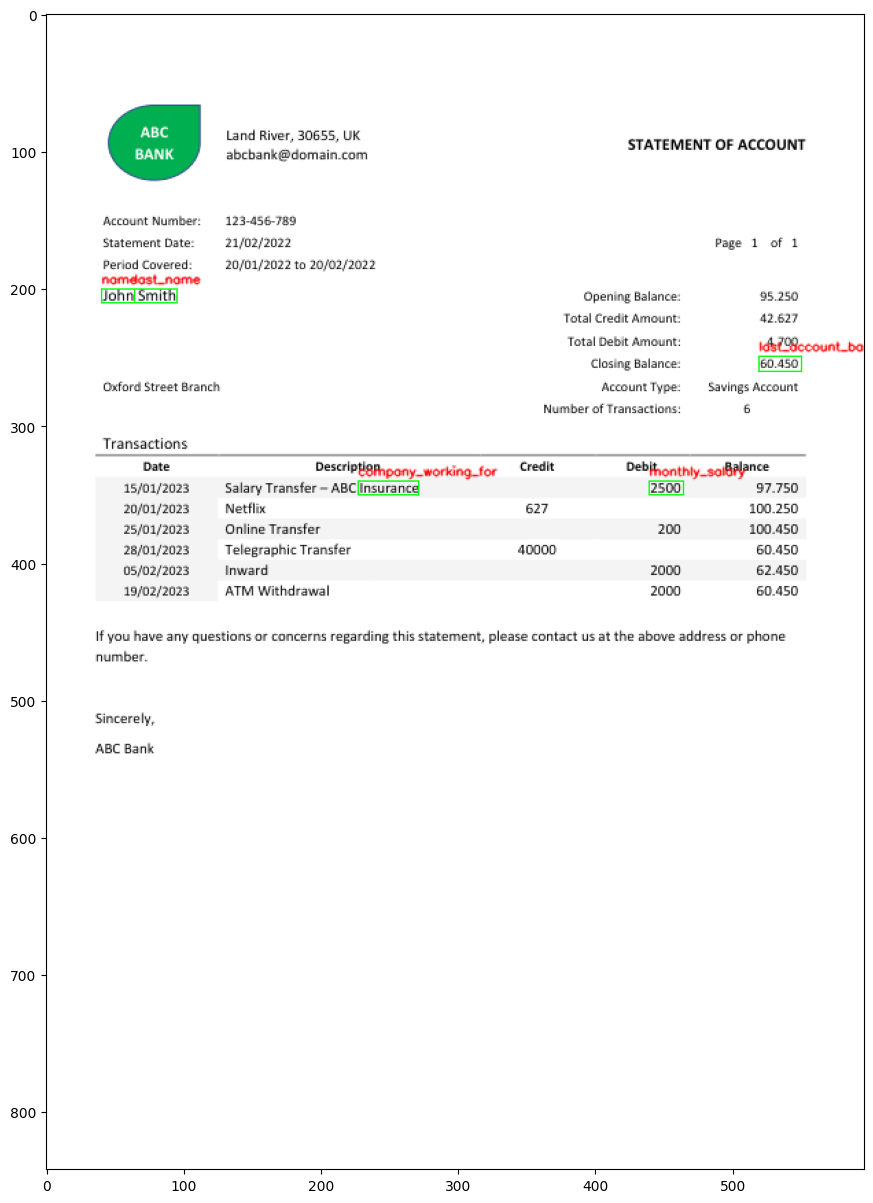

,Page,Label,Value,Condifence
0,1,name,John,87.18
1,1,last_name,Smith,73.91
2,1,last_account_balance,60.450,64.17
3,1,company_working_for,Insurance,80.93
4,1,monthly_salary,2500,79.50


In [9]:
def parse_results_visualise(result_dict, document, document_no_ext, show_output):

    # Open PDF Document - Ready to convert to PNG
    pages = fitz.open(document)

    # Iterate through the Pages
    for page in pages:  
        # Convert to Image
        pix = page.get_pixmap()
        # Save as PNG File
        pix.save(f"{document_no_ext}-image-{page.number + 1}.png")
        
        
    # Create Empty DataFrame
    results_df = pd.DataFrame([], columns = ["Page", "Label", "Value", "Condifence"])

    # Iterate over Pages
    for page in result_dict['pages']:

        # Read in Image
        im = cv2.imread(f"{document_no_ext}-image-{page['pageNumber']}.png")

        # Get Dimensions of Image - For Scaling Later
        height, width, channels = im.shape

        # Iterate over Key Value Pairs and Respective Bounding Boxes
        for kv_pair in page['documentFields']:

            # Extract Relevant Data
            name = kv_pair['fieldLabel']['name']
            value = kv_pair['fieldValue']['value']
            confidence = round(kv_pair['fieldLabel']['confidence']*100, 2)

            # Add Key Values to Results List
            results_list = [page['pageNumber'], name, value, confidence]

            # Append to Results List to DataFrame
            a_series = pd.Series(results_list, index = results_df.columns)
            results_df = results_df.append(a_series, ignore_index=True)

            # Extract Bounding Boxes
            bounding_polygon_x1 = int(kv_pair['fieldValue']['boundingPolygon']['normalizedVertices'][0]['x']*width)
            bounding_polygon_y1 = int(kv_pair['fieldValue']['boundingPolygon']['normalizedVertices'][0]['y']*height)
            bounding_polygon_x2 = int(kv_pair['fieldValue']['boundingPolygon']['normalizedVertices'][2]['x']*width)
            bounding_polygon_y2 = int(kv_pair['fieldValue']['boundingPolygon']['normalizedVertices'][2]['y']*height)

            # Build Points as Tuples - Coordinates of Opposite Points
            coordinates_pt1 = (bounding_polygon_x1, bounding_polygon_y1)
            coordinates_pt2 = (bounding_polygon_x2, bounding_polygon_y2)

            # Draw Bounding Boxes - Pass in Image, Top Left and Bottom Right Points, Colour, Line Thickness
            cv2.rectangle(im, coordinates_pt1, coordinates_pt2, (0, 255, 0), 1)

            # Plot Label just above the Top Left Point, Set Font, Size, Colour, Thickness, Line Type
            cv2.putText(im, name, (bounding_polygon_x1, bounding_polygon_y1-4), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0,0,255), 1, cv2.LINE_AA)

            # Write Image with Bounding Boxes to file
            cv2.imwrite(f"{document_no_ext}-result-{page['pageNumber']}.png",im)
            
    
    if show_output == 'Y':
        # Iterate over Pages
        for page in result_dict['pages']:

            # Create Figure and Set Size
            fig = plt.figure()
            fig.set_size_inches(12, 15)

            # Read in Image
            img = mpimg.imread(f"{document_no_ext}-result-{page['pageNumber']}.png")

            # Plot Image
            imgplot = plt.imshow(img)
            plt.show(imgplot)
            

    return results_df



# Parse Results and Visualise Outputs
results_df = parse_results_visualise(result_dict, document, document_no_ext, 'Y')

# Preview Data
results_df.head(10)
        

## **1.5 Bank Statement Function used in Gradio**

In [10]:
def predict_bank_statements(FILE):
    
    # Authenticate Against OCI
    config = oci_authenticate('y')
    
    # Define PDF Document
    document = FILE.name

    # Remove Document Extension - Used later when save with new extension
    document_no_ext = document[:-4]

    # Encode PDF Document as base64
    with open(document, "rb") as document_file:
        document_encoded = base64.b64encode(document_file.read()).decode('utf-8')
               
    # Call Key Value Extraction Function
    processor_response, output_location = kv_extraction(config, document_encoded)
    
    # Retrieve Results from Object Storage
    result_dict = retrieve_results(config, processor_response, output_location)
    
    # Parse Results and Visualise Outputs
    results_df = parse_results_visualise(result_dict, document, document_no_ext, 'N')
    
    # Extract Result Values to be returned
    name = results_df[results_df['Label']=='name']['Value'].values[0]
    last_name = results_df[results_df['Label']=='last_name']['Value'].values[0]
    last_account_balance = results_df[results_df['Label']=='last_account_balance']['Value'].values[0]
    company_working_for = results_df[results_df['Label']=='company_working_for']['Value'].values[0]
    monthly_salary = results_df[results_df['Label']=='monthly_salary']['Value'].values[0]
    page1_salary = cv2.imread(f'{document_no_ext}-result-1.png')
    
    return name, last_name, last_account_balance, company_working_for, monthly_salary, page1_salary

----

# **2. Extracting key values from Salary Statement**

---

## **2.1 Document Understanding Functions (Similar to Bank Statement)**

Processor call succeeded with status: 201.




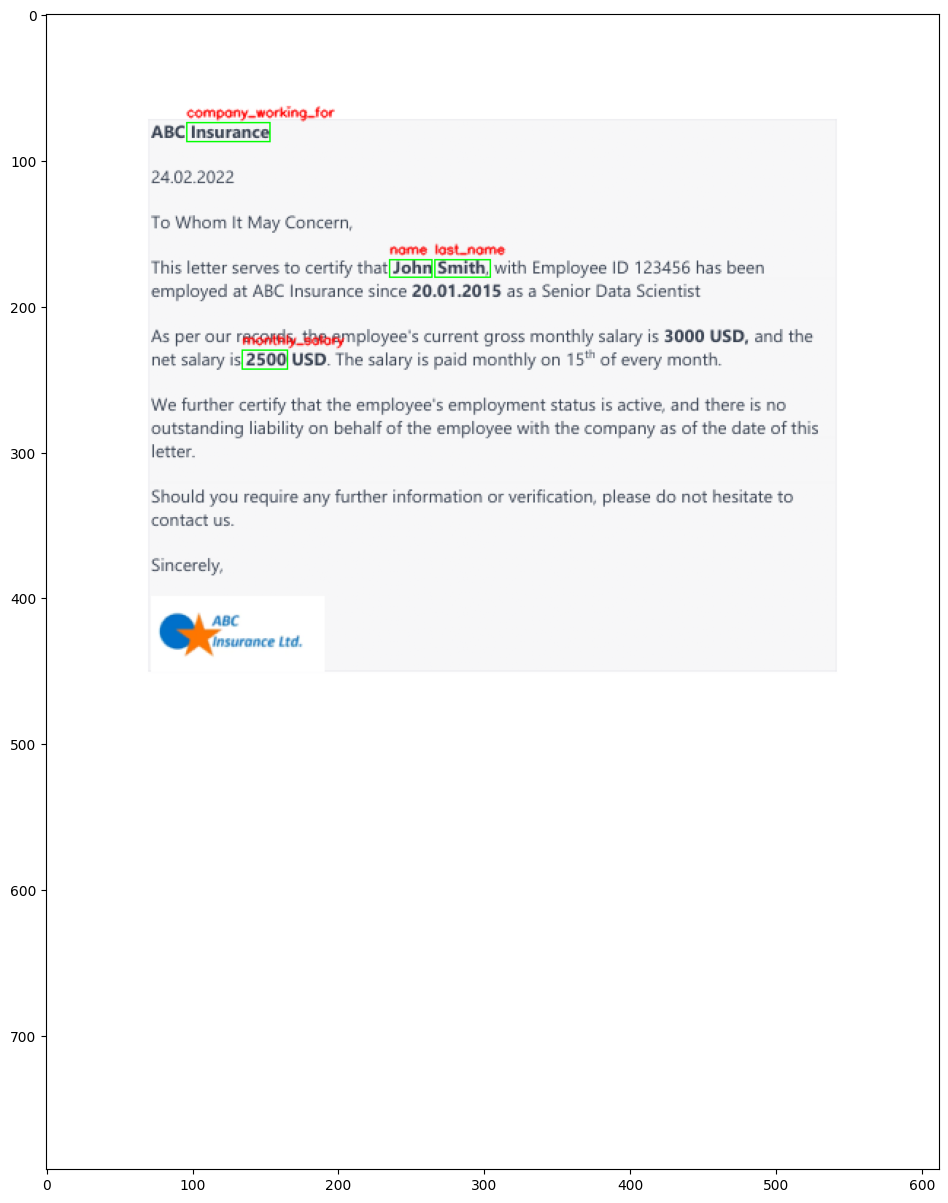

,Page,Label,Value,Condifence
0,1,company_working_for,Insurance,57.36
1,1,name,John,42.18
2,1,last_name,"Smith,",47.39
3,1,monthly_salary,2500,60.08


In [11]:
# Define PDF Document
document_sal = r"salary_certificate_1.pdf"

# Remove Document Extension - Used later when save with new extension
document_no_ext_sal = document_sal[:-4]

# Encode PDF Document as base64
with open(document_sal, "rb") as document_file_sal:
    document_encoded_sal = base64.b64encode(document_file_sal.read()).decode('utf-8')
    
    
def kv_extraction_salary(config, document_encoded_sal):
    
    # Compartment where Processor Job will be created
    COMPARTMENT_ID = "ocid1.compartment.oc1..aaaaaaaae3n6r6hrjipbap2hojicrsvkzatrtlwvsyrpyjd7wjnw4za3m75q"
    
    ### salary statement model
    # Custom MP DUS Key Value Model ID
    MODEL_ID = "ocid1.aidocumentmodel.oc1.eu-frankfurt-1.amaaaaaangencdyafjjsepoqgnxzt5ihirfpwhs7uxzhdqa3upquxilqm7xq"
    
    # Define AI Services Client
    aiservicedocument_client = oci.ai_document.AIServiceDocumentClient(config=config)
    
    # Instantiate Document Key-Value Feature - Pass in Model ID
    key_value_extraction_feature = oci.ai_document.models.DocumentKeyValueExtractionFeature(model_id=MODEL_ID)

    # Save to a list - add multiple DUS features here if required
    features = [key_value_extraction_feature]
    
    # Define Document Input
    input_loc = oci.ai_document.models.InlineDocumentContent(data=document_encoded_sal)
    
    # Setup the Output Location where the Job Results will be stored
    output_location = oci.ai_document.models.OutputLocation()
    output_location.namespace_name = "frqap2zhtzbe"
    output_location.bucket_name = "West_BP"
    output_location.prefix = "DocumentUnderstanding_output"


    # Define the Features for DUS
    processor_config = oci.ai_document.models.GeneralProcessorConfig(features=features)
    
    # Create a Job for Key Value Extraction Feature
    kv_job_details_sal = oci.ai_document.models.CreateProcessorJobDetails(
                        display_name=str(uuid.uuid4()),
                        compartment_id=COMPARTMENT_ID,
                        input_location=input_loc,
                        output_location = output_location,
                        processor_config=processor_config)

    # Extecute DUS Job - Response is an Object pointing to Deatils of Job
    processor_response_sal = aiservicedocument_client.create_processor_job(create_processor_job_details=kv_job_details_sal)

    print("Processor call succeeded with status: {}.\n\n".format(processor_response_sal.status))
    
    
    return processor_response_sal, output_location
    
    
# Call Key Value Extraction Function
processor_response_sal, output_location = kv_extraction_salary(config, document_encoded_sal)

def retrieve_results_salary_statement(config, processor_response_sal, output_location):
    
    # Get Job ID from Response
    processor_job_id = processor_response_sal.data.id

    # Instantiate Object Storage Client
    object_storage_client = oci.object_storage.ObjectStorageClient(config=config)

    # Getting Results from Object Storage
    object_response_sal = object_storage_client.get_object(namespace_name=output_location.namespace_name,
                                                           bucket_name=output_location.bucket_name,
                                                           object_name="{}/{}/_/results/defaultObject.json".format(
                                                               output_location.prefix, processor_job_id))
    
    # Decode Response
    result_sal = str(object_response_sal.data.content.decode())

    # Convert Response to Python Dictionary
    result_dict_sal = json.loads(result_sal)
    
    return result_dict_sal


# Retrieve Results from Object Storage
result_dict_sal = retrieve_results_salary_statement(config, processor_response_sal, output_location)

def parse_results_visualise_salary(result_dict_sal, document_sal, document_no_ext_sal, show_output):

    # Open PDF Document - Ready to convert to PNG
    pages = fitz.open(document_sal)

    # Iterate through the Pages
    for page in pages:  
        # Convert to Image
        pix = page.get_pixmap()
        # Save as PNG File
        pix.save(f"{document_no_ext_sal}-image-{page.number + 1}.png")
        
        
    # Create Empty DataFrame
    results_df_sal = pd.DataFrame([], columns = ["Page", "Label", "Value", "Condifence"])

    # Iterate over Pages
    for page in result_dict_sal['pages']:

        # Read in Image
        im = cv2.imread(f"{document_no_ext_sal}-image-{page['pageNumber']}.png")

        # Get Dimensions of Image - For Scaling Later
        height, width, channels = im.shape

        # Iterate over Key Value Pairs and Respective Bounding Boxes
        for kv_pair in page['documentFields']:

            # Extract Relevant Data
            name = kv_pair['fieldLabel']['name']
            value = kv_pair['fieldValue']['value']
            confidence = round(kv_pair['fieldLabel']['confidence']*100, 2)

            # Add Key Values to Results List
            results_list_sal = [page['pageNumber'], name, value, confidence]

            # Append to Results List to DataFrame
            a_series = pd.Series(results_list_sal, index = results_df_sal.columns)
            results_df_sal = results_df_sal.append(a_series, ignore_index=True)

            # Extract Bounding Boxes
            bounding_polygon_x1 = int(kv_pair['fieldValue']['boundingPolygon']['normalizedVertices'][0]['x']*width)
            bounding_polygon_y1 = int(kv_pair['fieldValue']['boundingPolygon']['normalizedVertices'][0]['y']*height)
            bounding_polygon_x2 = int(kv_pair['fieldValue']['boundingPolygon']['normalizedVertices'][2]['x']*width)
            bounding_polygon_y2 = int(kv_pair['fieldValue']['boundingPolygon']['normalizedVertices'][2]['y']*height)

            # Build Points as Tuples - Coordinates of Opposite Points
            coordinates_pt1 = (bounding_polygon_x1, bounding_polygon_y1)
            coordinates_pt2 = (bounding_polygon_x2, bounding_polygon_y2)

            # Draw Bounding Boxes - Pass in Image, Top Left and Bottom Right Points, Colour, Line Thickness
            cv2.rectangle(im, coordinates_pt1, coordinates_pt2, (0, 255, 0), 1)

            # Plot Label just above the Top Left Point, Set Font, Size, Colour, Thickness, Line Type
            cv2.putText(im, name, (bounding_polygon_x1, bounding_polygon_y1-4), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0,0,255), 1, cv2.LINE_AA)

            # Write Image with Bounding Boxes to file
            cv2.imwrite(f"{document_no_ext_sal}-result-{page['pageNumber']}.png",im)
            
    
    if show_output == 'Y':
        # Iterate over Pages
        for page in result_dict['pages']:

            # Create Figure and Set Size
            fig = plt.figure()
            fig.set_size_inches(12, 15)

            # Read in Image
            img_sal = mpimg.imread(f"{document_no_ext_sal}-result-{page['pageNumber']}.png")

            # Plot Image
            imgplot_sal = plt.imshow(img_sal)
            plt.show(imgplot_sal)
            

    return results_df_sal



# Parse Results and Visualise Outputs
results_df_sal = parse_results_visualise_salary(result_dict_sal, document_sal, document_no_ext_sal, 'Y')

# Preview Data
results_df_sal.head(10)

## **2.2 Salary Statement Function used in Gradio**

In [12]:
def predict_salary_statements(FILE):
    
    # Authenticate Against OCI
    config = oci_authenticate('y')
    
    # Define PDF Document
    document_sal = FILE.name

    # Remove Document Extension - Used later when save with new extension
    document_no_ext_sal = document_sal[:-4]

    # Encode PDF Document as base64
    with open(document_sal, "rb") as document_file_sal:
        document_encoded_sal = base64.b64encode(document_file_sal.read()).decode('utf-8')
               
    # Call Key Value Extraction Function
    processor_response, output_location = kv_extraction_salary(config, document_encoded_sal)
    
    # Retrieve Results from Object Storage
    result_dict_sal = retrieve_results_salary_statement(config, processor_response, output_location)
    
    # Parse Results and Visualise Outputs
    results_df_sal = parse_results_visualise_salary(result_dict_sal, document_sal, document_no_ext_sal, 'N')
    
    # Extract Result Values to be returned
    name_xx = results_df_sal[results_df_sal['Label']=='name']['Value'].values[0]
    last_name_xx = results_df_sal[results_df_sal['Label']=='last_name']['Value'].values[0]
    company_working_for_xx = results_df_sal[results_df_sal['Label']=='company_working_for']['Value'].values[0]
    monthly_salary_xx = results_df_sal[results_df_sal['Label']=='monthly_salary']['Value'].values[0]
    page1_salary = cv2.imread(f'{document_no_ext_sal}-result-1.png')
    
    return name_xx, last_name_xx, company_working_for_xx, monthly_salary_xx, page1_salary

-----

# **3. Gradio**

---

## **3.1 Functions used by Gradio**

In [13]:
############################################################
################ Sending email
################
############################################################

def send_email(x1, x6):
    email_address = application_email_adress
    email_password = application_password

    # create email
    msg = EmailMessage()
    msg['Subject'] = "Request Form - You are almost there!"
    msg['From'] = email_address
    msg['To'] = x6
    
    #create content
    body_email = "Dear " + x1 + "," + """Thank you for submitting your online loan application with ABC Bank. We appreciate your interest in our lending services and we would like to inform you that your application is currently being processed.

    However, in order to complete the loan application process, we require additional documentation from you. Specifically, we need a salary certificate and a bank statement for the past three months to verify your income and financial stability.

    Please provide us with the requested documentation at your earliest convenience. You may upload the documents in online application form or send us via e-mail. If you have any questions or concerns, please do not hesitate to contact us.

    We value your time and appreciate your cooperation in this matter. Once we have received the required documentation, we will review your application and contact you with our decision as soon as possible.

    Thank you for choosing ABC Bank for your lending needs. We look forward to serving you.

    Sincerely,

    Kubra Canel, Loan Officer, ABC Bank"""  
    
    msg.set_content(body_email)

    # send email
    with smtplib.SMTP_SSL('smtp.gmail.com', 465) as smtp:
        smtp.login(email_address, email_password)
        smtp.send_message(msg)
    
    return msg

############################################################
################ Survey function, for sending confirmation
################
############################################################

def survey_function(x1, x2, x3, x4, x5, x6):
    output_survey = "Thank you " + x1 + " for your request. The requested loan is " + str(x4) + " for a period of " + str(x5) + " months. A confirmation email will be send to " + x6 + "."
    
    #send the email with only name as input.
    send_email(x1, x6)
    
    return output_survey

############################################################
################ Call KYC Data
################
############################################################

def get_data(x2, x2a, x3a, x4, x5, x3):
    input_for_model = [[x2, x2a, x3a, x4, x5, x3]]
    input_for_model_df = pd.DataFrame(input_for_model, columns = ["Age", "Marital Status", "Loan Type", "Loan Amount", "Loan Length", "Gender"])
    copy_df = input_for_model_df.copy()
   
    x_out = "KYC / AML data has been extracted from API"
    x_out_df = copy_df
    x_out_df['KYC_total_amount'] = random.randint(5000, 178950)
    x_out_df['KYC_#_loans'] = random.randint(2, 15)
    x_out_df['KYC_#_credits'] = random.randint(15, 35)
    x_out_df['KYC_risk_score'] = random.randint(0, 10)
    
    textual_out = "All information and checks have been uploaded to the database. Please review the dashboards."

    return copy_df, x_out, textual_out, x_out_df

############################################################
################ Cross check input from two different PDFS
################
############################################################

def cross_check_function(name_x, name_xx, company_working_for_x, company_working_for_xx, monthly_salary_x, monthly_salary_xx):
    
    name_x_new = name_x
    name_xx_new = name_xx
    company_working_for_x_new = company_working_for_x
    company_working_for_xx_new = company_working_for_xx
    monthly_salary_x_new = monthly_salary_x
    monthly_salary_xx_new = monthly_salary_xx
    
    if name_x_new == name_xx_new:
        out1 = "The same first name"
        
    else:
        out1 = "Different first names"

    
    if company_working_for_x_new == company_working_for_xx_new:
        out2 = "The same company"
    
    else:
        out2 = "Not the same company"
    
    if monthly_salary_x_new == monthly_salary_xx_new:
        out3 = "The same monthly salary"
    else:
        out3 = "Not the same salary"
    
    return name_x_new, name_xx_new, out1, company_working_for_x_new, company_working_for_xx_new, out2, monthly_salary_x_new, monthly_salary_xx_new, out3


## **4.2 Deploy Gradio app**

In [ ]:
with gr.Blocks() as demo:

    gr.Markdown("Extract key information for credit check and cross check")
   
    with gr.Tab("Request a Loan Form"):
        x1 = gr.Text(label="Name", info="Please add your full name") 
        x2 = gr.Number(label='Age', info='In years, must be greater than 0')
        x2a = gr.Radio(["Single", "Married", "Divorced"], label="Marital status")
        x3 = gr.Radio(["Male", "Female", "Do not want to answer"], label="Please indicate your gender")
        x3a = gr.Radio(["Housing", "Need", "Auto", "Education"], label="Loan type")
        x4 = gr.Number(label = "Total Loan Amount")
        x5 = gr.Radio(["12", "24", "84", "252"], label = "Duration of Loan in months")
        x6 = gr.Text(label="Email", info="Please add your email") 
        button_0 = gr.Button("Submit your form")
        output_survey = gr.Text(label = "Confirmation")

        
    with gr.Tab("Extract Bank Account Details"):
        inputs_1 = gr.File(type='file', label='Bank Statement')
        button_1 = gr.Button("Extract Details from PDF")
        name_x = gr.Text(label="First name")
        last_name_x = gr.Text(label="Last name")
        last_account_balance_x = gr.Text(label="Last account balance")
        company_working_for_x = gr.Text(label="Company working for")
        monthly_salary_x = gr.Text(label="Stated monthly salary")
        page1_x = gr.Image(label='Page 1 Bank')
           
        
    with gr.Tab("Extract Salary Statement Details"):
        inputs_2 = gr.File(type='file', label='Salary Statement')
        button_2 = gr.Button("Extract Details from PDF")
        name_xx = gr.Text(label="First name")
        last_name_xx = gr.Text(label="Last name")
        company_working_for_xx = gr.Text(label="Company working for")
        monthly_salary_xx = gr.Text(label="Stated monthly salary")
        page1_salary = gr.Image(label='Page 1 Salary')


    with gr.Tab("Cross-checks Bank & Salary statements"):
        button_2a = gr.Button("Initiate cross check")
        
        with gr.Row():
            name_x_new = gr.Text(label='First name in Salary statement')
            name_xx_new = gr.Text(label='First name in Bank statement')
            with gr.Column(scale=1, min_width=600):
                out1 = gr.Text(label="Cross-check First name")
        with gr.Row():
            company_working_for_x_new = gr.Text(label='Company name in Salary statement')
            company_working_for_xx_new = gr.Text(label='Company name in Bank statement')
            with gr.Column(scale=1, min_width=600):
                out2 = gr.Text(label="Cross-check Company working for")   
        with gr.Row():
            monthly_salary_x_new = gr.Text(label='Salary in Salary statement')
            monthly_salary_xx_new = gr.Text(label='Salary name in Bank statement')
            with gr.Column(scale=1, min_width=600):
                out3 = gr.Text(label="Cross-check monthyly salary")             
    
    with gr.Tab("KYC and Push"):
        button_3 = gr.Button("Get KYC / AML Data")
        with gr.Row():
            copy_df = gr.Dataframe()
            x_out = gr.Text(label="KYC Data / AML Status")
        button_4 = gr.Button("Push application to database")
        with gr.Row():
            x_out_df = gr.Dataframe()
            textual_out = gr.Text(label="Result of push to database")

    with gr.Accordion("Open for more detailed information!"):
        gr.Markdown("Please start at tab 1, and follow the steps.")
        
    ## survey
    button_0.click(survey_function, inputs=[x1, x2, x3, x4, x5, x6], outputs=output_survey)
    ## bank statement
    button_1.click(predict_bank_statements, inputs=[inputs_1], outputs=[name_x, last_name_x, last_account_balance_x, company_working_for_x, monthly_salary_x, page1_x])
    ## salary statement
    button_2.click(predict_salary_statements, inputs=[inputs_2], outputs=[name_xx, last_name_xx, company_working_for_xx, monthly_salary_xx, page1_salary])
    #cross check
    button_2a.click(cross_check_function, inputs=[name_x, name_xx, company_working_for_x, company_working_for_xx, monthly_salary_x, monthly_salary_xx], outputs=[name_x_new, name_xx_new, out1, company_working_for_x_new, company_working_for_xx_new, out2, monthly_salary_x_new, monthly_salary_xx_new, out3]) 
    #credit scoring
    button_3.click(get_data, inputs=[x2, x2a, x3a, x4, x5, x3], outputs=[copy_df, x_out])
    button_4.click(get_data, inputs=[x2, x2a, x3a, x4, x5, x3], outputs = [x_out_df, textual_out])

# demo.queue()
demo.launch(width=800, height=1100, share=True, debug=True)


/home/datascience/conda/fdf_conda/lib/python3.7/site-packages/gradio/deprecation.py:44: UserWarning: You have unused kwarg parameters in Textbox, please remove them: {'info': 'Please add your full name'}
  f"You have unused kwarg parameters in {cls}, please remove them: {kwargs}"
/home/datascience/conda/fdf_conda/lib/python3.7/site-packages/gradio/deprecation.py:44: UserWarning: You have unused kwarg parameters in Number, please remove them: {'info': 'In years, must be greater than 0'}
  f"You have unused kwarg parameters in {cls}, please remove them: {kwargs}"
/home/datascience/conda/fdf_conda/lib/python3.7/site-packages/gradio/deprecation.py:44: UserWarning: You have unused kwarg parameters in Textbox, please remove them: {'info': 'Please add your email'}
  f"You have unused kwarg parameters in {cls}, please remove them: {kwargs}"


Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://c39ce50e-d643-4e5e.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces



Authentication Successful!

OCI User Logged In: oracleidentitycloudservice/bob.peulen@oracle.com
OCI User Email: None
Processor call succeeded with status: 201.



Authentication Successful!

OCI User Logged In: oracleidentitycloudservice/bob.peulen@oracle.com
OCI User Email: None
Processor call succeeded with status: 201.




In [ ]:
# Shutdown Server
#demo.close()

## **4.3 Last Gradio - Approval of Loan Application**

In [ ]:
def approval_function(a1, a2, a3, b1):
    
    output_approval = "Loan officer ID " + a1 + " has updated status of client ID " + a2 + " to " + a3 + ", with comments: " + b1 + ", a confirmation e-mail has been sent to client."
    
    return output_approval

with gr.Blocks() as demo:

    gr.Markdown("Decline or Approve Loan")
   
    with gr.Tab("Approval Form"):
        a1 = gr.Text(label="Approver ID", info="Please add your Company ID") 
        a2 = gr.Text(label='Customer ID', info='Please add Customer ID')
        a3 = gr.Radio(["Approve Loan", "Decline Loan", "Put Loan on Hold"], label="Update Status to:")
        b1 = gr.Text(label="Comments", info="Add your comments for internal system") 
        approval = gr.Button("Submit")
        output_approval = gr.Text(label = "Results of Submit")
        
    ## approve or not
    approval.click(approval_function, inputs=[a1, a2, a3, b1], outputs=output_approval)

# demo.queue()
demo.launch(width=800, height=1100, share=True, debug=True)


/home/datascience/conda/fdf_conda/lib/python3.7/site-packages/gradio/deprecation.py:44: UserWarning: You have unused kwarg parameters in Textbox, please remove them: {'info': 'Please add your Company ID'}
  f"You have unused kwarg parameters in {cls}, please remove them: {kwargs}"
/home/datascience/conda/fdf_conda/lib/python3.7/site-packages/gradio/deprecation.py:44: UserWarning: You have unused kwarg parameters in Textbox, please remove them: {'info': 'Please add Customer ID'}
  f"You have unused kwarg parameters in {cls}, please remove them: {kwargs}"
/home/datascience/conda/fdf_conda/lib/python3.7/site-packages/gradio/deprecation.py:44: UserWarning: You have unused kwarg parameters in Textbox, please remove them: {'info': 'Add your comments for internal system'}
  f"You have unused kwarg parameters in {cls}, please remove them: {kwargs}"


Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://e008cd79-f255-404e.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


</br></br><h1 style='color:#09a2b3'><center> End of Notebook </center></h1>